In [78]:
!pip install scipy

In [79]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Best CPU usage for VINA 

In [18]:
cpu_usage_trials = pd.read_csv('output_run_vina_different_cpu/vina_times.txt', names=['ZINC_ID', 'cpu', 'duration'])

In [19]:
cpu_usage_trials.groupby(['cpu']).mean()

,duration
cpu,
1,113.85
2,57.45
3,40.40
4,29.45
5,23.55
6,23.75
7,18.55
8,18.85
9,19.05


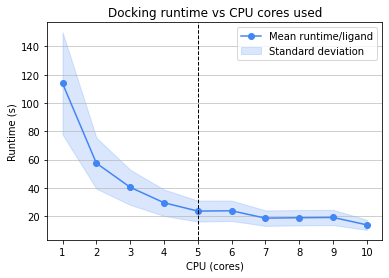

In [20]:
cpu =  range(1,len(cpu_usage_trials.groupby(['cpu']).mean())+1)
duration = cpu_usage_trials.groupby(['cpu']).mean()['duration']
duration_std = cpu_usage_trials.groupby(['cpu']).std()['duration']
sns.despine()
plt.plot(cpu,duration,  '-o', color='#4285f4')
plt.fill_between(cpu, duration - duration_std, duration + duration_std, color='#4285f4', alpha=0.2)
plt.xticks(cpu)
plt.title('Docking runtime vs CPU cores used')
plt.xlabel('CPU (cores)')
plt.ylabel('Runtime (s)')
plt.grid(axis='y', alpha=0.75)
plt.axvline(5, color='k', linestyle='dashed', linewidth=1)
plt.legend(['Mean runtime/ligand', 'Standard deviation'])
plt.savefig('vina_different_cpu_runtimes.pdf',bbox_inches = "tight")

# VINA vs VINA GPU scores

### Read in the docking data

In [21]:
labeled_zincs_vina =[]
with open("vina_vs_vina_gpu_scores/docking_chunk_0.txt") as file:
    wake_up = False
    for line in file:
        line  = line.rstrip()
        if line and line[0:4] == "ZINC":
            zinc_id = line
        if wake_up:
            line_list = line.split()
            binding_affinity = line_list[1]
            wake_up=False
        if line and line[0:5] == "-----":
            wake_up=True
        if line and line[0:4] == "@@@@":
            labeled_zincs_vina.append((binding_affinity,zinc_id))
            

labeled_zincs_vina_gpu =[]
with open("vina_vs_vina_gpu_scores/docking_vina_gpu_chunk_0.txt") as file:
    wake_up = False
    for line in file:
        line  = line.rstrip()
        if line and line[0:4] == "ZINC":
            zinc_id = line
        if wake_up:
            line_list = line.split()
            binding_affinity = line_list[1]
            wake_up=False
        if line and line[0:5] == "-----":
            wake_up=True
        if line and line[0:4] == "@@@@":
            if(binding_affinity != ""):
                labeled_zincs_vina_gpu.append((binding_affinity,zinc_id))
            zinc_id = ""
            binding_affinity = ""

### Put data into dataframes

In [22]:
labeled_zincs_vina_df = pd.DataFrame(labeled_zincs_vina, columns=['r_i_docking_score', 'ZINC_ID'])
labeled_zincs_vina_gpu_df = pd.DataFrame(labeled_zincs_vina_gpu, columns=['r_i_docking_score', 'ZINC_ID'])

### Merge dataframes on ZINC_ID

In [23]:
merged_labeled = pd.merge(labeled_zincs_vina_df, labeled_zincs_vina_gpu_df, on='ZINC_ID', how='left')
clean_merged_labeled = merged_labeled[merged_labeled['r_i_docking_score_y'].notna()]

### Get scores

In [40]:
scores = np.array(list(clean_merged_labeled['r_i_docking_score_x'])).astype(float)
scores_gpu = np.array(list(clean_merged_labeled['r_i_docking_score_y'])).astype(float)

x = list(range(0,len(scores)))

### Get absolute score differences

In [41]:
differences = [abs(float(a_i) - float(b_i)) for a_i, b_i in zip(scores_gpu, scores)]
numpy_differences = np.array(differences)

### Pearson correlation

In [80]:
scipy.stats.pearsonr(scores, scores_gpu)

(0.9573094738567476, 0.0)

### Plot correlation

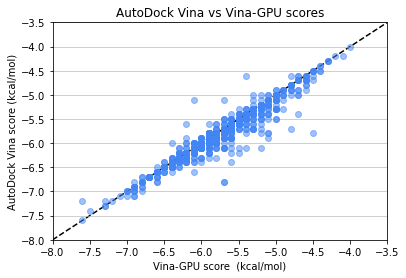

In [75]:
plt.scatter(scores_gpu,scores,color='#4285f4',zorder=2,alpha=0.5)
plt.plot(range(-8, -2),range(-8, -2), color='k',linestyle='dashed',zorder=1)
plt.title('AutoDock Vina vs Vina-GPU scores')
plt.xlabel('Vina-GPU score  (kcal/mol)')
plt.ylabel('AutoDock Vina score (kcal/mol)')
plt.grid(axis='y', alpha=0.75)
plt.xlim([-8, -3.5])
plt.ylim([-8, -3.5])
plt.savefig('correlation_vina_vs_vina_gpu.pdf',bbox_inches = "tight")
plt.show()

### Plot histogram of absolute score differences

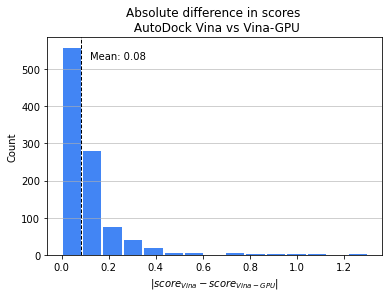

In [76]:
plt.hist(numpy_differences, bins=15, rwidth=0.9,
                   color='#4285f4')
plt.title('Absolute difference in scores \n AutoDock Vina vs Vina-GPU')
plt.xlabel('|$score_{Vina} - score_{Vina-GPU}$|')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.axvline(numpy_differences.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(numpy_differences.mean()*1.5, max_ylim*0.9, 'Mean: {:.2f}'.format(numpy_differences.mean()))
plt.savefig('vina_vs_vina_gpu_histogram_absolute_difference.pdf', dpi=300, bbox_inches = "tight")

# VINA vs VINA GPU runtime

In [81]:
vina_times = pd.read_csv('output_run_compare_runtime_vina/vina_times.txt', names=['ZINC_ID','duration'])
vina_gpu_times = pd.read_csv('output_run_compare_runtime_vina_gpu/vina_times.txt', names=['ZINC_ID','duration'])

In [85]:
numpy_vina_times = np.array(list(vina_times['duration']))
numpy_vina_gpu_times = np.array(list(vina_gpu_times['duration']))

vina_std = numpy_vina_times.std()
vina_gpu_std = numpy_vina_gpu_times.std()

vina_mean = numpy_vina_times.mean()
vina_gpu_mean = numpy_vina_gpu_times.mean()

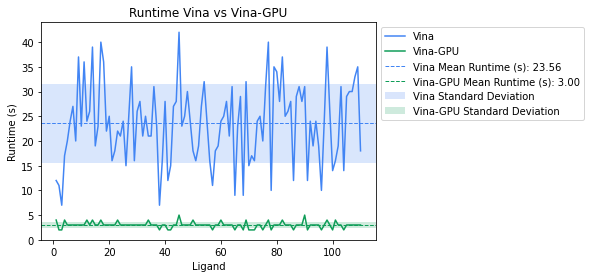

In [101]:

plt.plot(range(1,len(numpy_vina_times)+1),numpy_vina_times, color='#4285f4')
plt.plot(range(1,len(numpy_vina_gpu_times)+1),numpy_vina_gpu_times, color='#0f9d58ff')

plt.title('Runtime Vina vs Vina-GPU')
plt.xlabel('Ligand')
plt.ylabel('Runtime (s)')
plt.axhline(vina_mean, color='#4285f4', linestyle='dashed', linewidth=1)
plt.axhline(vina_gpu_mean, color='#0f9d58ff', linestyle='dashed', linewidth=1)
plt.axhspan(vina_mean - vina_std, vina_mean + vina_std, facecolor='#4285f4', alpha=0.2)
plt.axhspan(vina_gpu_mean - vina_gpu_std, vina_gpu_mean + vina_gpu_std, facecolor='#0f9d58ff', alpha=0.2)

plt.legend(['Vina', 'Vina-GPU', 
            'Vina Mean Runtime (s): {:.2f}'.format(numpy_vina_times.mean()), 
            'Vina-GPU Mean Runtime (s): {:.2f}'.format(numpy_vina_gpu_times.mean()),
            'Vina Standard Deviation',
            'Vina-GPU Standard Deviation'],
          bbox_to_anchor=(1, 1))
plt.savefig('vina_vs_vina_gpu_runtimes.pdf',bbox_inches = "tight")

In [88]:
min_xlim

-4.45

In [89]:
max_xlim

115.45